In [1]:
import torch
from superclap.model_train import SuperCLAPTrainer
from superclap.config import config
from superclap.alignment import align_textgrid_with_source_text
from superclap.audio import load_mono_audio, spectogram
from training.datasets import load_item, collate, load_prepared_sampler, extract_training_data, load_prepared_item, load_prepared_sampler
import matplotlib.pyplot as plt

In [2]:
sampler = load_prepared_sampler()
checkpoint = torch.load(f'./output/exp-02.pt', map_location="cpu")
model = SuperCLAPTrainer()
model.load_state_dict(checkpoint['model'])
model.eval()
print(checkpoint['step'])

159000


In [3]:
# waveform, spec, audio_segments, combined_alignments = load_item("./external_datasets/librilight-processed/100/2315/01_baum_sea_fairies_64kb_0002")
# waveform2, spec2, audio_segments2, combined_alignments2 = load_item("./external_datasets/librilight-processed/2032/1555/pygmalionsspectacles_weinbaum_cml_64kb_0046")
# audio, audio_lengths, alignments = collate([(audio_segments, combined_alignments), (audio_segments2, combined_alignments2)])
# text_embeddings, audio_embeddings, loss = model(audio = audio, audio_lengths = audio_lengths, alignment = alignments)
# similarity_matrix = audio_embeddings @ audio_embeddings.T

In [4]:
def show_similarity(mt):
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(32, 32))
    
    # Display the similarity matrix as an image
    im = ax.imshow(mt.detach(), cmap='viridis', interpolation='nearest')
    
    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Cosine Similarity', rotation=-90, va="bottom")
    ax.set_title('Similarity Matrix')
    
    
    # Adjust the layout and display the plot
    fig.tight_layout()
    plt.show()

In [5]:
# source_index = 116
# count = 10
# print("From: ", ph[source_index])
# top_k = torch.topk(similarity_matrix[source_index], count + 1).indices
# _, ax = plt.subplots(len(top_k), 1, figsize=(1, count))
# ax[0].imshow(audio_segments[source_index].T, vmin=-10, vmax=0, origin="lower", aspect="auto")
# for i in range(1, len(top_k)):
#     print(ph[top_k[i]])
#     print("Index: ", str(top_k[i].item()), "similarity: " + str(similarity_matrix[source_index][top_k[i]].item()))
#     ax[i].imshow(audio_segments[top_k[i]].T, vmin=-10, vmax=0, origin="lower", aspect="auto")
#     ax[i].set_title("Index: " + str(top_k[i].item()))


In [6]:
# s = load_prepared_item("./datasets/prepared/librilight-processed/14/342/canterburytales_09_chaucer_64kb_0003.pt")
# # print(s[1])
# extract_training_data(s, phoneme_id = 416)

In [10]:
phoneme = None
samples_count = 512
padded_specs, out_specs_length, padded_tokens, out_tokens_length, padded_phonemes, out_phonemes_length, out_phonemes_index, out_tokens_segment, ids, ids_names = sampler(samples_count, phoneme_id = phoneme, output_ids = True, output_phoneme_names = True)
embeddings = model.audio_embeddings(padded_specs, out_specs_length)
embeddings_sim = embeddings @ embeddings.T
embeddings_sim[torch.eye(embeddings_sim.shape[0], dtype=torch.bool)] = float('-inf')
# show_similarity(embeddings_sim)

In [11]:
# Find the indices of the maximum value in the similarity matrix
max_indices = torch.argmax(embeddings_sim)

# Retrieve the row and column indices of the maximum value
row_index = max_indices // embeddings_sim.shape[0]
col_index = max_indices % embeddings_sim.shape[0]

print(row_index, col_index)

tensor(158) tensor(184)


Index:  184 similarity: 0.9999998807907104 ɱ librilight-medium-processed/707/1103/canyouforgiveher_31_trollope_64kb_0028
Index:  21 similarity: 0.7072471380233765 ʒ librilight-medium-processed/2136/2558/unclesilas_60_lefanu_64kb_0001
Index:  470 similarity: 0.6608233451843262 ɾ̃ librilight-medium-processed/167/601/selborne_04_tennant_14-22_white_64kb_0015
Index:  154 similarity: 0.6150661110877991 ɹ librilight-processed/107/2871/tramp_25_twain_64kb_0002
Index:  68 similarity: 0.5847028493881226 ŋ librilight-medium-processed/204/3458/sonsandlovers_07_lawrence_64kb_0066
Index:  280 similarity: 0.5768582820892334 ɹ librilight-medium-processed/4010/3264/unspokensermons_23_macdonald_64kb_0113
Index:  244 similarity: 0.5445447564125061 j librilight-medium-processed/3020/2741/redbadgeofcouragev2_03_scrane_64kb_0010
Index:  381 similarity: 0.5374753475189209 ɑ librilight-medium-processed/1065/773/historyofengland02ch08_08_macaulay_64kb_0020
Index:  464 similarity: 0.5283012390136719 aj librili

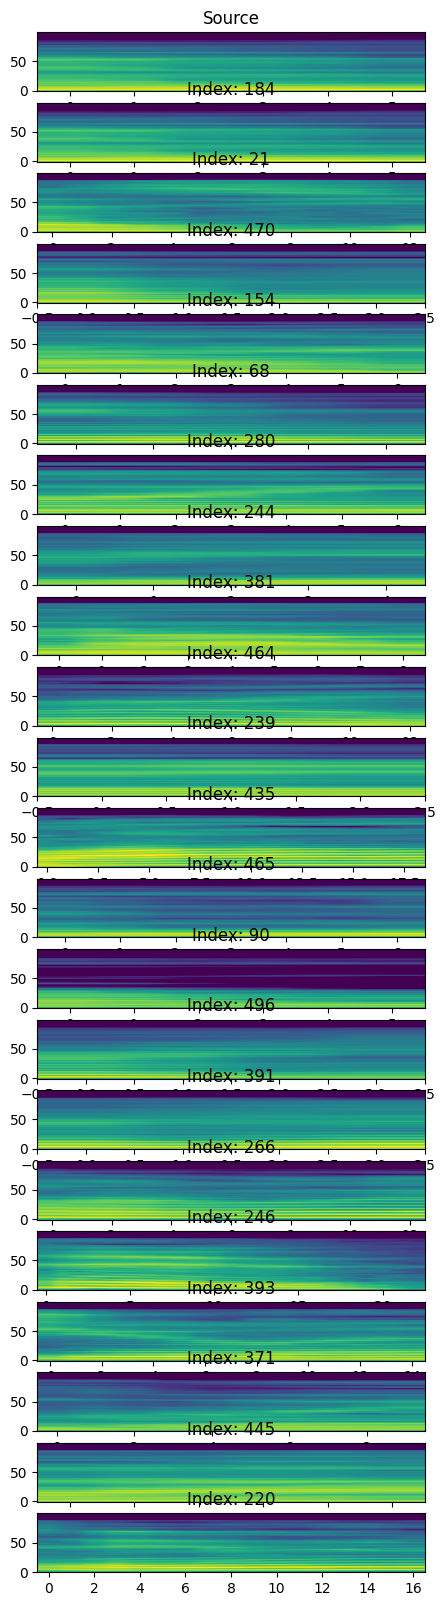

In [12]:
source_index = row_index
count = 20
top_k = torch.topk(embeddings_sim[source_index], count + 1).indices
_, ax = plt.subplots(len(top_k) + 1, 1, figsize=(5, count))
ax[0].imshow(padded_specs[source_index, :out_specs_length[source_index].item(), :].T, vmin=-10, vmax=0, origin="lower", aspect="auto")
ax[0].set_title("Source")
for i in range(len(top_k)):
    print("Index: ", str(top_k[i].item()), "similarity: " + str(embeddings_sim[source_index][top_k[i]].item()), ids_names[top_k[i]], ids[top_k[i]])
    ax[i + 1].imshow(padded_specs[top_k[i], :out_specs_length[top_k[i]].item(), :].T, vmin=-10, vmax=0, origin="lower", aspect="auto")
    ax[i + 1].set_title("Index: " + str(top_k[i].item()))